In [73]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [74]:
file = uproot.open("tracking_losses_ntuple_Dst0ToD0EE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")


#selektiere nur elektronen von D*0->D0ee und nur solche mit einem momentum von unter 5 GeV 
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p < 5e3)] #D: 2591
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p < 5e3)] #D: 1908

#ak.num(lost, axis=0)

In [75]:
def t_eff(found, lost):
    sel = found["energy"]
    des = lost["energy"]
    return ak.count(sel,axis=None)/(ak.count(sel,axis=None)+ak.count(des,axis=None))

t_eff(found, lost)

0.5759057568348522

In [76]:
#finden wir die elektronen die keine bremsstrahlung gemacht haben mit hoher effizienz?
nobrem_found = found[found["brem_photons_pe_length"]==0]
nobrem_lost = lost[lost["brem_photons_pe_length"]==0]

"""
die effizienz mit der wir elektronen finden, die keine bremsstrahlung gemacht haben, ist nicht besonders gut, aber trotzdem besser als
für alle elektronen.
Auch hier handelt es sich um eine recht geringe sample size (~350)
"""

t_eff(nobrem_found, nobrem_lost)
#ak.num(nobrem_lost, axis=0)

0.7960893854748603

In [77]:
#wie viel energie relativ zur anfangsenergie verlieren die elektronen durch bremstrahlung und hat das einen einfluss darauf ob wir sie finden oder nicht?
brem_found = found[found["brem_photons_pe_length"]!=0]
energy_found = ak.to_numpy(brem_found["energy"])
eph_found = ak.to_numpy(ak.sum(brem_found["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_found = eph_found/energy_found


brem_lost = lost[lost["brem_photons_pe_length"]!=0]
energy_lost = ak.to_numpy(brem_lost["energy"])
eph_lost = ak.to_numpy(ak.sum(brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_lost = eph_lost/energy_lost

t_eff(brem_found,brem_lost)

0.5568703211784594

In [78]:
mean_energyloss_found = ak.mean(energyloss_found)
mean_energyloss_lost = ak.mean(energyloss_lost)
print("mean energyloss relative to initial energy (found): ", mean_energyloss_found)
print("mean energyloss relative to initial energy (lost): ", mean_energyloss_lost)

mean energyloss relative to initial energy (found):  0.4422334194682742
mean energyloss relative to initial energy (lost):  0.5885317187224427


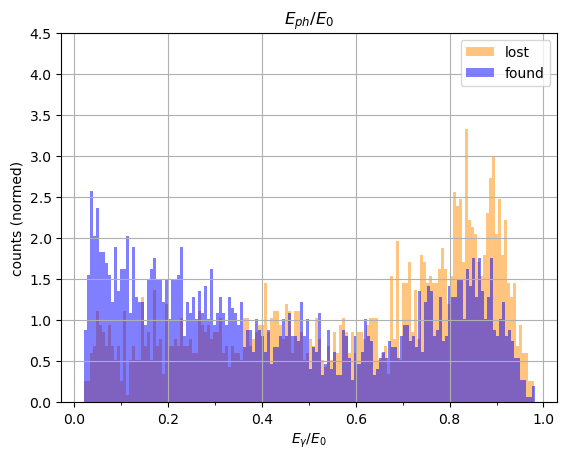

In [79]:
plt.hist(energyloss_lost, bins=150, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
plt.hist(energyloss_found, bins=150, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.xticks(np.arange(0,1.1,0.1), minor=True,)
plt.yticks(np.arange(0,5,0.5), minor=True)
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("counts (normed)")
plt.title(r'$E_{ph}/E_0$')
plt.legend()
plt.grid()

"""
found: elektronen verlieren durchschnittlich 0.44 ihrer anfangsenergie durch bremsstrahlung
lost: elektronen verlieren durchschnittlich 0.59 ihrer anfangsenergie durch bremsstrahlung

-> lost electrons lose slightly more energy than found electrons. This is however nowhere near as extreme as for the B decay
"""

plt.show()

In [80]:
#ist die shape der teilspur im scifi anders? (koenntest du zum beispiel durch vergleich der verteilungen der fit parameter studieren,
#in meiner thesis findest du das fitmodell -- ist einfach ein polynom dritten grades)
z_ref=8520 #mm

def scifi_track(z, a, b, c, d):
    return a + b*(z-z_ref) + c*(z-z_ref)**2 + d*(z-z_ref)**3

def z_mag(xv, zv, tx, a, b):
    """ optical centre of the magnet is defined as the intersection between the trajectory tangents before and after the magnet

    Args:
        xv (double): velo x track
        zv (double): velo z track
        tx (double): velo x slope
        a (double): ax parameter of track fit
        b (double): bx parameter of track fit

    Returns:
        double: z_mag
    """
    return (xv-tx*zv-a+b*z_ref)/(b-tx)

In [81]:
scifi_found = found[found["scifi_hit_pos_x_length"]>3]
scifi_lost = lost[lost["scifi_hit_pos_x_length"]>3]

scifi_x_found = scifi_found["scifi_hit_pos_x"]
scifi_z_found = scifi_found["scifi_hit_pos_z"]

tx_found = scifi_found["velo_track_tx"]

scifi_x_lost = scifi_lost["scifi_hit_pos_x"]
scifi_z_lost = scifi_lost["scifi_hit_pos_z"]

tx_lost = scifi_lost["velo_track_tx"]

xv_found = scifi_found["velo_track_x"]
zv_found = scifi_found["velo_track_z"]

xv_lost = scifi_lost["velo_track_x"]
zv_lost = scifi_lost["velo_track_z"]



#ak.num(scifi_found["energy"], axis=0)
#scifi_found.snapshot()

In [82]:
scifi_fitpars_found = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]))
    scifi_fitpars_found.begin_list()
    scifi_fitpars_found.real(popt[0])
    scifi_fitpars_found.real(popt[1])
    scifi_fitpars_found.real(popt[2])
    scifi_fitpars_found.real(popt[3])
    scifi_fitpars_found.end_list()

scifi_fitpars_lost = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]))
    scifi_fitpars_lost.begin_list()
    scifi_fitpars_lost.real(popt[0])
    scifi_fitpars_lost.real(popt[1])
    scifi_fitpars_lost.real(popt[2])
    scifi_fitpars_lost.real(popt[3])
    scifi_fitpars_lost.end_list()


scifi_fitpars_lost = scifi_fitpars_lost.to_numpy()
scifi_fitpars_found = scifi_fitpars_found.to_numpy()



dtx_found = scifi_fitpars_found[:,1] - tx_found
dtx_lost = scifi_fitpars_lost[:,1] - tx_lost


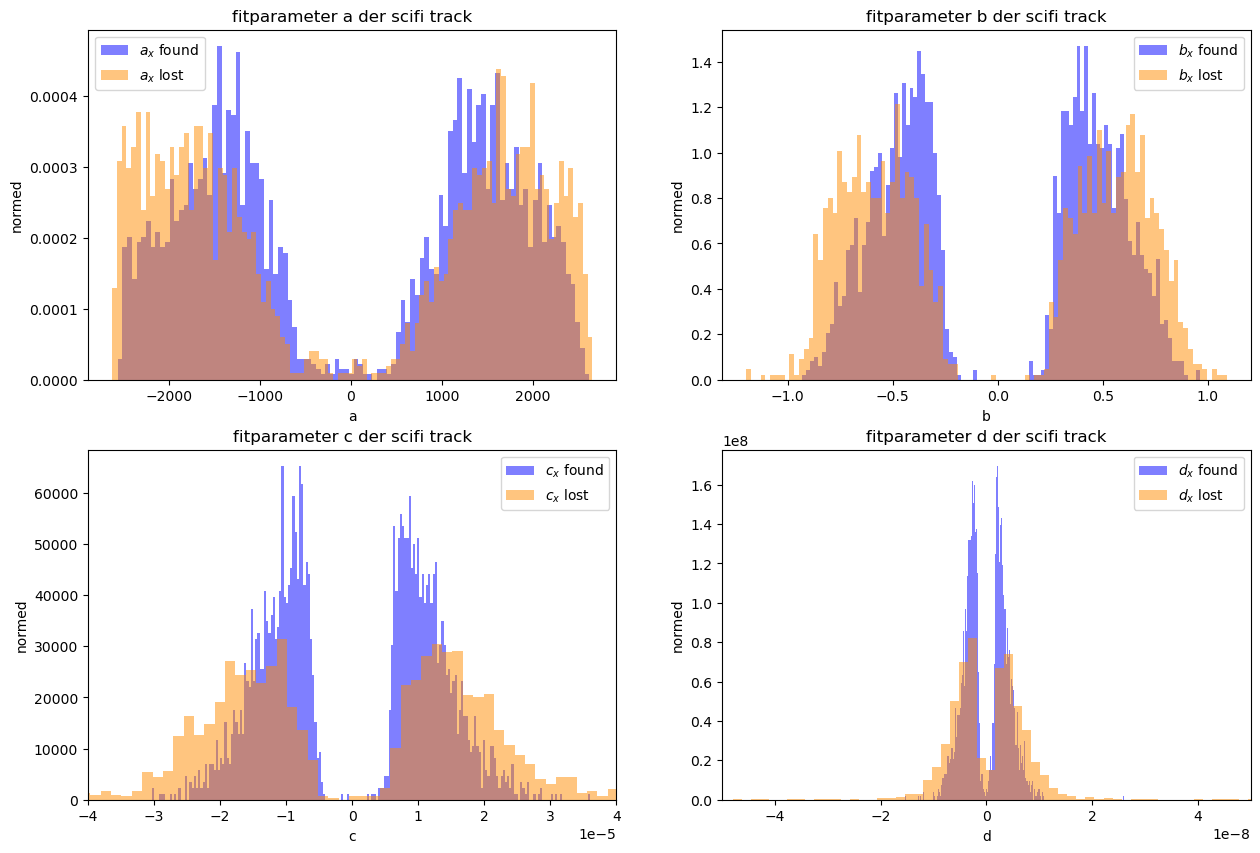

In [83]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax0.hist(scifi_fitpars_found[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$a_x$ found")
ax0.hist(scifi_fitpars_lost[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$a_x$ lost")
ax0.set_xlabel("a")
ax0.set_ylabel("normed")
ax0.set_title("fitparameter a der scifi track")
ax0.legend()

ax1.hist(scifi_fitpars_found[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$b_x$ found")
ax1.hist(scifi_fitpars_lost[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$b_x$ lost")
ax1.set_xlabel("b")
ax1.set_ylabel("normed")
ax1.set_title("fitparameter b der scifi track")
ax1.legend()

ax2.hist(scifi_fitpars_found[:,2], bins=200, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$c_x$ found")
ax2.hist(scifi_fitpars_lost[:,2], bins=1000, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$c_x$ lost")
ax2.set_xlim([-4e-5,4e-5])
ax2.set_xticks(np.arange(-4e-5,4.5e-5,1e-5),minor=False)
ax2.set_xlabel("c")
ax2.set_ylabel("normed")
ax2.set_title("fitparameter c der scifi track")
ax2.legend()

ax3.hist(scifi_fitpars_found[:,3], bins=200, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$d_x$ found")
ax3.hist(scifi_fitpars_lost[:,3], bins=1000, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$d_x$ lost")
ax3.set(xlim=(-5e-8,5e-8))
#ax3.text(-4e-8,3e8,"d negligible <1e-7")
ax3.set_xlabel("d")
ax3.set_ylabel("normed")
ax3.set_title("fitparameter d der scifi track")
ax3.legend()

"""
a_x: virtual hit on the reference plane
"""

plt.show()

In [84]:
print("found")
print("a = ", str(np.mean(scifi_fitpars_found[:,0])))
print("b = ", str(np.mean(scifi_fitpars_found[:,1])))
print("c = ", str(np.mean(scifi_fitpars_found[:,2])))
print("d = ", str(np.mean(scifi_fitpars_found[:,3])))

print("lost")
print("a = ", str(np.mean(scifi_fitpars_lost[:,0])))
print("b = ", str(np.mean(scifi_fitpars_lost[:,1])))
print("c = ", str(np.mean(scifi_fitpars_lost[:,2])))
print("d = ", str(np.mean(scifi_fitpars_lost[:,3])))

found
a =  18.04180550457298
b =  0.0057651944487250376
c =  9.480277789440454e-08
d =  -4.452015498411874e-11
lost
a =  -35.48371609662243
b =  -0.010382326385451382
c =  -6.208301288913938e-07
d =  9.580933791481267e-11


In [85]:
np.min(scifi_fitpars_found[:,3])

-1.5438992626615335e-08

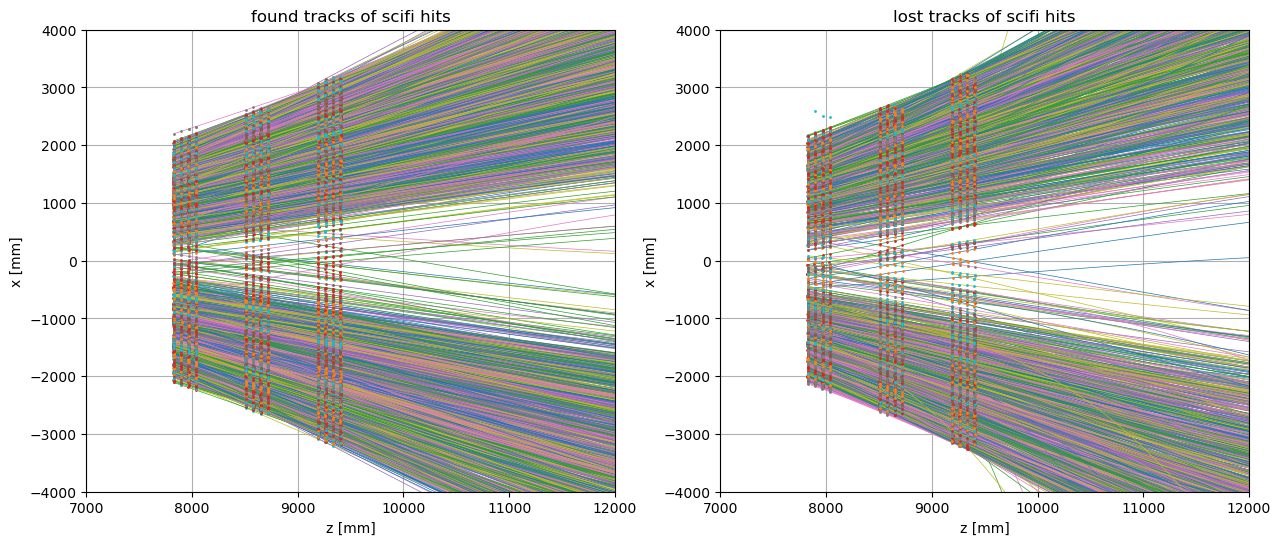

In [86]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_found[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_found[i])
    ax0.plot(z_coord, fit, "-", lw=0.5)
    ax0.errorbar(ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]),fmt=".",ms=2)

#ax0.legend()
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks of scifi hits")
ax0.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax0.grid()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_lost[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_lost[i])
    ax1.plot(z_coord, fit, "-", lw=0.5)
    ax1.errorbar(ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]),fmt=".",ms=2)

#ax1.legend()
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks of scifi hits")
ax1.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax1.grid()

plt.show()

In [87]:
#vergleich der zmag werte
zmag_found = z_mag(xv_found, zv_found, tx_found, scifi_fitpars_found[:,0], scifi_fitpars_found[:,1])
zmag_lost = z_mag(xv_lost, zv_lost, tx_lost, scifi_fitpars_lost[:,0], scifi_fitpars_lost[:,1])
zmag_lost = zmag_lost[~np.isnan(zmag_lost)]
zmag_found = zmag_found[~np.isnan(zmag_found)]

print("found \nzmag = ", str(np.mean(zmag_found)))
print("lost \nzmag = ", str(np.mean(zmag_lost)))

found 
zmag =  5318.452650242005
lost 
zmag =  5425.137423441005


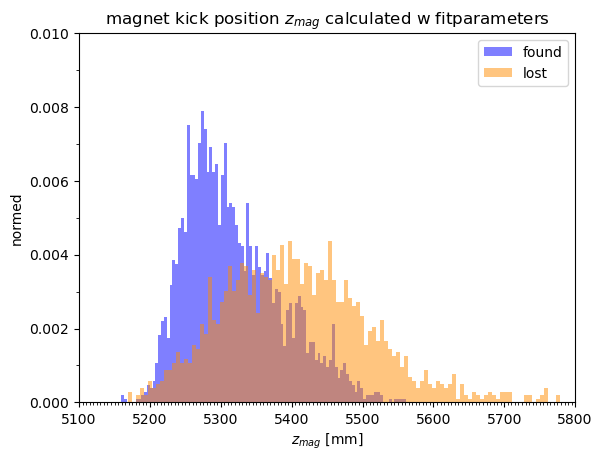

In [88]:
plt.hist(zmag_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.hist(zmag_lost, bins=3000, density=True, alpha=0.5, histtype="bar",color="darkorange", label="lost")
plt.xlabel("$z_{mag}$ [mm]")
plt.ylabel("normed")
plt.title("magnet kick position $z_{mag}$ calculated w fitparameters")
plt.legend()
plt.xticks(np.arange(5100,5805,5), minor=True)
plt.yticks(np.arange(0,0.011,0.001), minor=True)
plt.xlim(5100,5800)

"""
wir können definitiv einen unterschied zwischen den z_mag werten, bzw deren verteilungen für lost and found, erkennen
"""

plt.show()

In [102]:
shared = np.array([0,1,0,1,1,2])
len(shared)

6

In [104]:
#versuche teilchen von denselben events mit shared tracks zu finden. 
#idee: alle teilchen eines events sind durch event_count auffindbar. 
a_f_itr = found["event_count"].to_numpy()
f_itr = np.unique(a_f_itr)

"""
def shared_track(mc_arr, mc_itr):
    for itr in mc_itr: #iterate over events
        potential = mc_arr[mc_arr["event_count"]==itr] #holds all pt of a single event
        velo_idx = potential["velo_track_idx"].to_numpy()
        velo_idx_unis, mults = np.unique(velo_idx, return_counts=True)
        print(velo_idx_unis, mults)
        if any(x>1 for x in mults):
"""         

possibles = np.array([])

for itr in f_itr:
    temp = found[found["event_count"]==itr]
    if len(temp)<2:
        continue
    else:
        #iterate over cols in temp and append all with duplicate velo_track_idx, such that possibles is array with possible shared tracks particles
        
        


ValueError: cannot broadcast records in equal

In [42]:
ak.num(found["event_count"], axis=0)

2591

In [28]:
mo=found[(found["mother_key"]==3) & (found["mother_id"]==423)]
mo

"""
mother_key : event number
mother_id : specific event type
"""
ak.num(mo["energy"], axis=0)
#mother_key=3 : 9 particles
mo["velo_track_ty"].tolist()

[-0.03604912757873535,
 0.01677863299846649,
 0.03238071873784065,
 -0.009163273498415947,
 -0.022408662363886833,
 -0.004034307319670916,
 -0.01760791800916195,
 0.049464158713817596,
 -0.01695789396762848]

In [ ]:
"""
was meinst du? velo track sharen? wie überprüfe ich das? versuche ich einfach e teilchen mit identischen velo tracks und slopes zu finden?
benutze ich mother key um elektronen von gleichen events zu finden? meinst du wie viele elektronen vom selben event teilen sich einen track,
oder wie viele teilchen von unterschiedlichen events haben dieselben tracks?
"""
